In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models, utils
import numpy as np
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical

In [2]:
# Create list of all targets (minus background noise)
dataset_path = 'C:\\Users\\Greg\\ML\\Technical\\project\\git2\\monophonic_classfication_cnn\\padded'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)
numclasses = len(all_targets)
print(numclasses)

['A#3', 'A#4', 'A3', 'A4', 'B3', 'B4', 'C#3', 'C#4', 'C3', 'C4', 'D#3', 'D#4', 'D3', 'D4', 'E3', 'E4', 'F#3', 'F#4', 'F3', 'F4', 'G3', 'G4']
22


In [3]:
# Settings
feature_sets_path = 'C:\\Users\\Greg\\ML\\Technical\\project\\git2\\monophonic_classfication_cnn\\audioScripts'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'model.h5'
pitch = 'A#4'

In [4]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [6]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1024, 16, 16)
(128, 16, 16)
(128, 16, 16)


In [7]:
# Peek at labels
print(y_val)

[21.  9. 13.  0.  0. 10. 13. 13.  0. 13. 10.  9. 15.  0.  9. 18.  0. 20.
 11. 13.  8.  6. 12.  4.  2.  3.  7. 11.  5.  1.  5. 11.  4.  2.  8.  1.
  5.  2.  3.  6. 10.  7. 11. 13.  2. 17.  5. 11.  3.  5. 13.  2.  5. 10.
  5. 12.  9.  4.  8.  9. 18. 15.  4.  9.  4.  4.  6.  0.  5.  1.  4. 11.
 10. 13.  3.  4. 17. 15.  4. 20.  4. 15. 19.  5. 14. 21. 11.  6.  5. 11.
 20.  2.  1.  0.  2.  5.  3. 10. 17.  5.  3.  1. 17.  1. 20. 12. 17.  0.
 11. 14.  6.  4. 11. 10. 15.  0. 20. 14. 19. 13.  4.  0. 21. 18.  6. 11.
  8. 19.]


In [8]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
pitch_index = all_targets.index(pitch)
y_train = np.equal(y_train, pitch_index).astype('float64')
y_val = np.equal(y_val, pitch_index).astype('float64')
y_test = np.equal(y_test, pitch_index).astype('float64')

In [9]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.046875
0.953125


In [11]:
# View the dimensions of our input data
print(x_train.shape)

(1024, 16, 16)


In [12]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)


print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1024, 16, 16, 1)
(128, 16, 16, 1)
(128, 16, 16, 1)


In [13]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [14]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu',input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0

In [16]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [17]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
11/11 [==============================] - 1s 33ms/step - loss: 0.3848 - acc: 0.8633 - val_loss: 0.1655 - val_acc: 0.9531
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 0.2049 - acc: 0.9521 - val_loss: 0.1703 - val_acc: 0.9531
Epoch 3/30
11/11 [==============================] - 0s 13ms/step - loss: 0.1769 - acc: 0.9521 - val_loss: 0.1677 - val_acc: 0.9531
Epoch 4/30
11/11 [==============================] - 0s 13ms/step - loss: 0.1750 - acc: 0.9531 - val_loss: 0.1435 - val_acc: 0.9531
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 0.1562 - acc: 0.9521 - val_loss: 0.1655 - val_acc: 0.9531
Epoch 6/30
11/11 [==============================] - 0s 13ms/step - loss: 0.1652 - acc: 0.9473 - val_loss: 0.2074 - val_acc: 0.9531
Epoch 7/30
11/11 [==============================] - 0s 13ms/step - loss: 0.1587 - acc: 0.9521 - val_loss: 0.1562 - val_acc: 0.9531
Epoch 8/30
11/11 [==============================] - 0s 13ms/step - loss: 0.1502 - a

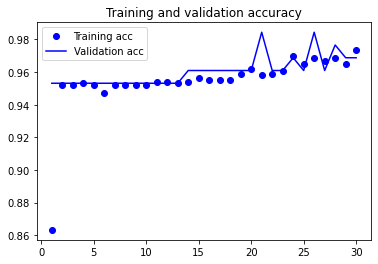

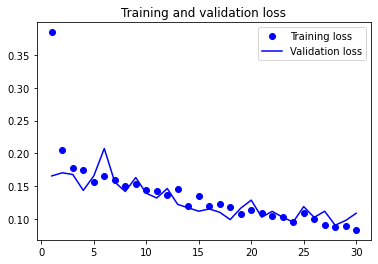

In [18]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Save the model as a file
models.save_model(model, model_filename)

In [20]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

13
16
29
33
35
42
45
93
112
122


In [21]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(1, 50):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

1/1 [==============================] - 0s 106ms/step
Answer: 0.0  Prediction: [[0.0004679]]
1/1 [==============================] - 0s 18ms/step
Answer: 0.0  Prediction: [[0.01780551]]
1/1 [==============================] - 0s 18ms/step
Answer: 0.0  Prediction: [[2.0047373e-05]]
1/1 [==============================] - 0s 17ms/step
Answer: 0.0  Prediction: [[0.00023861]]
1/1 [==============================] - 0s 17ms/step
Answer: 0.0  Prediction: [[5.4090873e-05]]
1/1 [==============================] - 0s 17ms/step
Answer: 0.0  Prediction: [[0.00469187]]
1/1 [==============================] - 0s 17ms/step
Answer: 0.0  Prediction: [[0.00082068]]
1/1 [==============================] - 0s 20ms/step
Answer: 0.0  Prediction: [[0.04307855]]
1/1 [==============================] - 0s 17ms/step
Answer: 0.0  Prediction: [[0.02719683]]
1/1 [==============================] - 0s 18ms/step
Answer: 0.0  Prediction: [[0.51962924]]
1/1 [==============================] - 0s 20ms/step
Answer: 0.0  Predictio

In [22]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.1824 - acc: 0.9453


[0.1823681741952896, 0.9453125]